![](https://i.ibb.co/MCMr2NJ/YOLO2-reduced.png)


Yolo tutorial: https://machinethink.net/blog/object-detection-with-yolo/

Yolo v3: Improvements and changes: https://towardsdatascience.com/yolo-v3-object-detection-53fb7d3bfe6b

## Stage 1: Install all dependencies and set up the environment



In [ ]:
!pip install tensorflow-gpu==2.0.0.beta1

In [ ]:
!pip install opencv-python==4.0.0.21

## Stage 2: Importing project dependencies

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras import Model
from tensorflow.keras.layers import (
    Add,
    Concatenate,
    Conv2D,
    Input,
    Lambda,
    LeakyReLU,
    MaxPool2D,
    UpSampling2D,
    ZeroPadding2D,
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import (
    binary_crossentropy,
    sparse_categorical_crossentropy
)

import matplotlib.pyplot as plt
tf.__version__

'2.0.0-beta1'

## Stage 3: Create all util functions

### Create a function that loads weights for the DarkNet model

In [ ]:
def load_darknet_weights(model, weights_file):
    '''
    Helper function used to load darknet weights.
    
    :param model: Object of the Yolo v3 model
    :param weights_file: Path to the file with Yolo V3 weights
    '''
    
    #Open the weights file
    wf = open(weights_file, 'rb')
    major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

    #Define names of the Yolo layers (just for a reference)    
    layers = [
              'yolo_darknet',
              'yolo_conv_0',
              'yolo_output_0',
              'yolo_conv_1',
              'yolo_output_1',
              'yolo_conv_2',
              'yolo_output_2',
          ]

    for layer_name in layers:
        sub_model = model.get_layer(layer_name)
        for i, layer in enumerate(sub_model.layers):
          
            
            if not layer.name.startswith('conv2d'):
                continue
                
            #Handles the special, custom Batch normalization layer
            batch_norm = None
            if i + 1 < len(sub_model.layers) and \
                    sub_model.layers[i + 1].name.startswith('batch_norm'):
                batch_norm = sub_model.layers[i + 1]

            filters = layer.filters
            size = layer.kernel_size[0]
            in_dim = layer.input_shape[-1]

            if batch_norm is None:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)
            else:
                # darknet [beta, gamma, mean, variance]
                bn_weights = np.fromfile(
                    wf, dtype=np.float32, count=4 * filters)
                # tf [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, size, size)
            conv_weights = np.fromfile(
                wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(
                conv_shape).transpose([2, 3, 1, 0])

            if batch_norm is None:
                layer.set_weights([conv_weights, conv_bias])
            else:
                layer.set_weights([conv_weights])
                batch_norm.set_weights(bn_weights)

    assert len(wf.read()) == 0, 'failed to read all data'
    wf.close()

In [ ]:
def draw_outputs(img, outputs, class_names):
    '''
    Helper, util, function that draws predictons on the image.
    
    :param img: Loaded image
    :param outputs: YoloV3 predictions
    :param class_names: list of all class names found in the dataset
    '''
    boxes, objectness, classes, nums = outputs
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    wh = np.flip(img.shape[0:2])
    for i in range(nums):
        x1y1 = tuple((np.array(boxes[i][0:2]) * wh).astype(np.int32))
        x2y2 = tuple((np.array(boxes[i][2:4]) * wh).astype(np.int32))
        img = cv2.rectangle(img, x1y1, x2y2, (255, 0, 0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
            x1y1, cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    return img

## Stage 4: Create YoloV3 helper functions

### Define YOLO's hyperparameters.

NOTE: These parameters are taken from the paper

In [ ]:
yolo_anchors = np.array([(10, 13), (16, 30), (33, 23), (30, 61), (62, 45),
                         (59, 119), (116, 90), (156, 198), (373, 326)],
                        np.float32) / 416

yolo_anchor_masks = np.array([[6, 7, 8], [3, 4, 5], [0, 1, 2]])

### Define the custom Batch norm layer

In [ ]:
class BatchNormalization(tf.keras.layers.BatchNormalization):
    """
    Making the custom Batch Normalization function, since the original one is not great for the inference time.
    """

    def call(self, x, training=False):
        if training is None:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

### Defining Darknet Conv layers functions

In [ ]:
def DarknetConv(x, filters, kernel_size, strides=1, batch_norm=True):
    '''
    Call this function to define a single Darknet convolutional layer
    
    :param x: inputs
    :param filters: number of filters in the convolutional layer
    :param kernel_size: Size of kernel in the Conv layer
    :param strides: Conv layer strides
    :param batch_norm: Whether or not to use the custom batch norm layer.
    '''
    #Image padding
    if strides == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
        
    #Defining the Conv layer
    x = Conv2D(filters=filters, kernel_size=kernel_size,
               strides=strides, padding=padding,
               use_bias=not batch_norm, kernel_regularizer=l2(0.0005))(x)
    
    if batch_norm:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

![](https://i.ibb.co/WKKMVpk/resblock.png)

Residual block great explanation: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec

In [ ]:
def DarknetResidual(x, filters):
    '''
    Call this function to define a single DarkNet Residual layer
    
    :param x: inputs
    :param filters: number of filters in each Conv layer.
    '''
    prev = x
    x = DarknetConv(x, filters // 2, 1)
    x = DarknetConv(x, filters, 3)
    x = Add()([prev, x])
    return x
  
  
def DarknetBlock(x, filters, blocks):
    '''
    Call this function to define a single DarkNet Block (made of multiple Residual layers)
    
    :param x: inputs
    :param filters: number of filters in each Residual layer
    :param blocks: number of Residual layers in the block
    '''
    x = DarknetConv(x, filters, 3, strides=2)
    for _ in range(blocks):
        x = DarknetResidual(x, filters)
    return x

### Define the DarkNet model

Where to find the architecture of the DarkNet: https://pjreddie.com/darknet/imagenet/

In [ ]:
def Darknet(name=None):
    '''
    The main function that creates the whole DarkNet.
    '''
    x = inputs = Input([None, None, 3])
    x = DarknetConv(x, 32, 3)
    x = DarknetBlock(x, 64, 1)
    x = DarknetBlock(x, 128, 2)  # skip connection
    x = x_36 = DarknetBlock(x, 256, 8)  # skip connection
    x = x_61 = DarknetBlock(x, 512, 8)
    x = DarknetBlock(x, 1024, 4)
    return tf.keras.Model(inputs=inputs, outputs=(x_36, x_61, x), name=name)

### Define the YOLO conv layer

In [ ]:
def YoloConv(filters, name=None):
    '''
    Call this function to define the Yolo Conv layer.
    
    :param flters: number of filters for the conv layer
    :param name: name of the layer
    '''
    def yolo_conv(x_in):
        if isinstance(x_in, tuple):
            inputs = Input(x_in[0].shape[1:]), Input(x_in[1].shape[1:])
            x, x_skip = inputs

            # concat with skip connection
            x = DarknetConv(x, filters, 1)
            x = UpSampling2D(2)(x)
            x = Concatenate()([x, x_skip])
        else:
            x = inputs = Input(x_in.shape[1:])

        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, filters, 1)
        return Model(inputs, x, name=name)(x_in)
      
    return yolo_conv

In [ ]:
def YoloOutput(filters, anchors, classes, name=None):
    '''
    This function defines outputs for the Yolo V3. (Creates output projections)
     
    :param filters: number of filters for the conv layer
    :param anchors: anchors
    :param classes: list of classes in a dataset
    :param name: name of the layer
    '''
    def yolo_output(x_in):
        x = inputs = Input(x_in.shape[1:])
        x = DarknetConv(x, filters * 2, 3)
        x = DarknetConv(x, anchors * (classes + 5), 1, batch_norm=False)
        x = Lambda(lambda x: tf.reshape(x, (-1, tf.shape(x)[1], tf.shape(x)[2],
                                            anchors, classes + 5)))(x)
        return tf.keras.Model(inputs, x, name=name)(x_in)
    return yolo_output

In [ ]:
def yolo_boxes(pred, anchors, classes):
    '''
    Call this function to get bounding boxes from network predictions
    
    :param pred: Yolo predictions
    :param anchors: anchors
    :param classes: List of classes from the dataset
    '''
    
    # pred: (batch_size, grid, grid, anchors, (x, y, w, h, obj, ...classes))
    grid_size = tf.shape(pred)[1]
    #Extract box coortinates from prediction vectors
    box_xy, box_wh, objectness, class_probs = tf.split(
        pred, (2, 2, 1, classes), axis=-1)

    #Normalize coortinates
    box_xy = tf.sigmoid(box_xy)
    objectness = tf.sigmoid(objectness)
    class_probs = tf.sigmoid(class_probs)
    pred_box = tf.concat((box_xy, box_wh), axis=-1)  # original xywh for loss

    # !!! grid[x][y] == (y, x)
    grid = tf.meshgrid(tf.range(grid_size), tf.range(grid_size))
    grid = tf.expand_dims(tf.stack(grid, axis=-1), axis=2)  # [gx, gy, 1, 2]

    box_xy = (box_xy + tf.cast(grid, tf.float32)) / \
        tf.cast(grid_size, tf.float32)
    box_wh = tf.exp(box_wh) * anchors

    box_x1y1 = box_xy - box_wh / 2
    box_x2y2 = box_xy + box_wh / 2
    bbox = tf.concat([box_x1y1, box_x2y2], axis=-1)

    return bbox, objectness, class_probs, pred_box

### Non-maxima suppression

Simple explanation of the Non-Maxima suppression algorithm:

https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/ 

In [ ]:
def yolo_nms(outputs, anchors, classes):
    '''
    Non maxima suppression algorithm implemented in the TensorFlow 2.0
    
    :param outputs: Yolo outputs
    :param anchors: anchors
    :param classes: classes in a dataset
    '''
    # boxes, conf, probs
    b, c, p = [], [], []
    
    #Extract boxes, confidences and types from the outputs
    for o in outputs:
        b.append(tf.reshape(o[0], (tf.shape(o[0])[0], -1, tf.shape(o[0])[-1])))
        c.append(tf.reshape(o[1], (tf.shape(o[1])[0], -1, tf.shape(o[1])[-1])))
        p.append(tf.reshape(o[2], (tf.shape(o[2])[0], -1, tf.shape(o[2])[-1])))

    #Convert tensors for each part of the output (boxes, confs, probs)
    bbox = tf.concat(b, axis=1)
    confidence = tf.concat(c, axis=1)
    class_probs = tf.concat(p, axis=1)

    
    scores = confidence * class_probs
    
    #Perform non maxima suppression
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(
            scores, (tf.shape(scores)[0], -1, tf.shape(scores)[-1])),
        max_output_size_per_class=100,
        max_total_size=100,
        iou_threshold=0.5,
        score_threshold=0.5
    )

    return boxes, scores, classes, valid_detections

## Stage 5: Create the Yolo V3 network

In [ ]:
def YoloV3(size=None, channels=3, anchors=yolo_anchors,
           masks=yolo_anchor_masks, classes=80, training=False):
  
    x = inputs = Input([size, size, channels])

    #Create a DarkNet with 106 layers
    x_36, x_61, x = Darknet(name='yolo_darknet')(x)

    x = YoloConv(512, name='yolo_conv_0')(x)
    output_0 = YoloOutput(512, len(masks[0]), classes, name='yolo_output_0')(x)

    x = YoloConv(256, name='yolo_conv_1')((x, x_61))
    output_1 = YoloOutput(256, len(masks[1]), classes, name='yolo_output_1')(x)

    x = YoloConv(128, name='yolo_conv_2')((x, x_36))
    output_2 = YoloOutput(128, len(masks[2]), classes, name='yolo_output_2')(x)

    if training:
        return Model(inputs, (output_0, output_1, output_2), name='yolov3')

    #Get 3 sized bounding boxes
    boxes_0 = Lambda(lambda x: yolo_boxes(x, anchors[masks[0]], classes),
                     name='yolo_boxes_0')(output_0)
    boxes_1 = Lambda(lambda x: yolo_boxes(x, anchors[masks[1]], classes),
                     name='yolo_boxes_1')(output_1)
    boxes_2 = Lambda(lambda x: yolo_boxes(x, anchors[masks[2]], classes),
                     name='yolo_boxes_2')(output_2)
    
    #Create YOLO v3 outputs
    outputs = Lambda(lambda x: yolo_nms(x, anchors, classes),
                     name='yolo_nms')((boxes_0[:3], boxes_1[:3], boxes_2[:3]))

    return Model(inputs, outputs, name='yolov3')

## Stage 6: Inference with the pre-trained YOLO v3

### Download YOLO v3 weights

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights -O ./yolov3.weights

--2019-07-11 17:22:48--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘./yolov3.weights’

./yolov3.weights    100%[===================>] 236.52M  23.4MB/s    in 11s     

2019-07-11 17:22:59 (21.5 MB/s) - ‘./yolov3.weights’ saved [248007048/248007048]



### Define the YOLO v3 model

In [ ]:
yolo = YoloV3()

In [ ]:
yolo.summary()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Model)            ((None, None, None,  40620640    input_1[0][0]                    
__________________________________________________________________________________________________
yolo_conv_0 (Model)             (None, None, None, 5 11024384    yolo_darknet[1][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Model)             (None, None, None, 2 2957312     yolo_conv_0[1][0]                
                                                                 yolo_darknet[1][1]          

### Load pre-trained weights

In [ ]:
load_darknet_weights(yolo,"./yolov3.weights")

In [ ]:
times = []

vid = cv2.VideoCapture("video.mp4")

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (int(vid.get(3)), int(vid.get(4))))

### Load the file with all class names

In [ ]:
class_names = [c.strip() for c in open("./coco.names").readlines()]
class_names[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

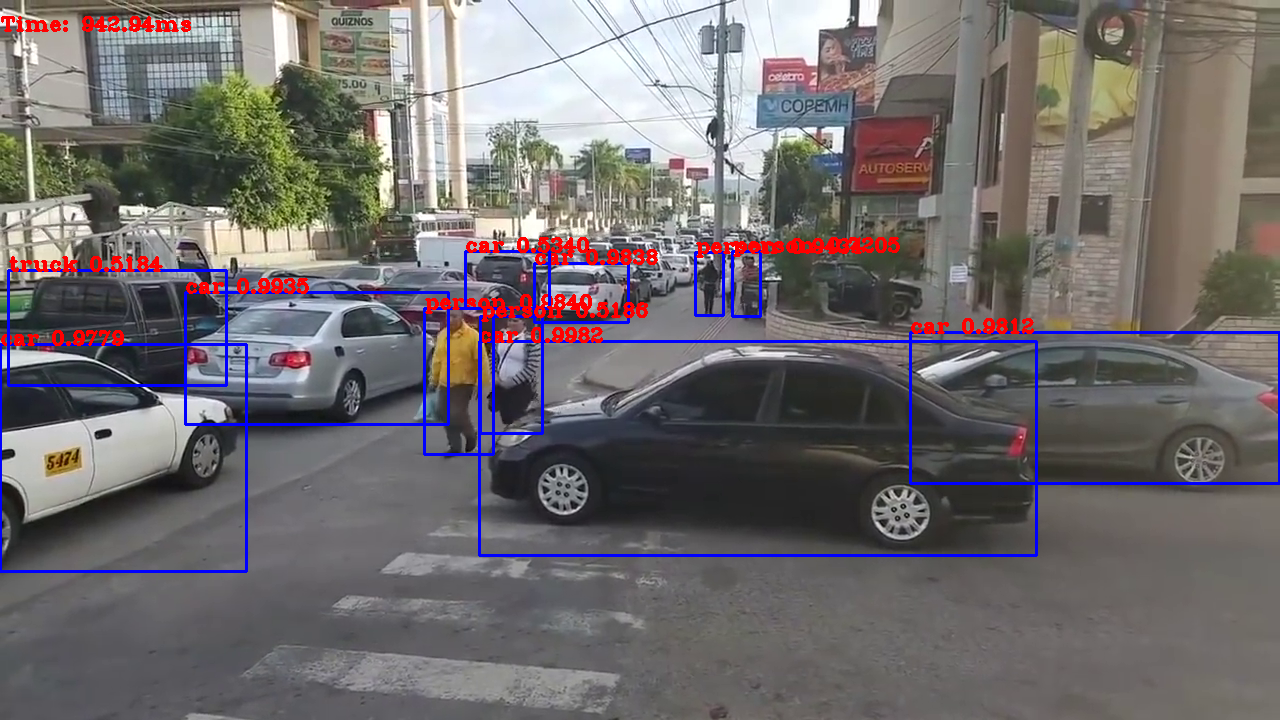

In [ ]:
import time
from google.colab.patches import cv2_imshow
import logging
from IPython import display

while True:
    _, img = vid.read()

    if img is None:
        logging.warning("Empty Frame")
        time.sleep(0.1)
        continue

    img_in = tf.expand_dims(img, 0)
    img_in = tf.image.resize(img_in, (416, 416))
    img_in = img_in / 255

    t1 = time.time()
    boxes, scores, classes, nums = yolo.predict(img_in)
    t2 = time.time()
    times.append(t2-t1)
    times = times[-20:]

    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    img = cv2.putText(img, "Time: {:.2f}ms".format(sum(times)/len(times)*1000), (0, 30),
                      cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 2)
    
    out.write(img)
    cv2_imshow(img)
    
    display.clear_output(wait=False)

    if cv2.waitKey(1) == ord('q'):
        break
        
_.release()
out.release()
cv2.destroyAllWindows()